Code to download and plot ATMOS Quality controlled 60-m tower data from https://www.atmos.anl.gov/ANLMET/text/

In [14]:
import numpy as np
import pandas as pd
import time
from datetime import timedelta, date
import wget
import matplotlib.pyplot as plt
import requests 
import os, glob
import re
import datetime 

In [2]:
# Download Quality controlled data from ATMOS 60-m Tower
year = 2019
while year < 2023:
    print(year)
    for month in months:
        to_download = base_url + str(year) + '/' + month + str(year)[-2:] + 'met.sum'
        response = requests.get(to_download)
        if response.status_code == 200:
            with open(f'atmos-tower-{year}-{month}.txt', 'wb') as file:
                file.write(response.content)     
        elif response.status_code ==  404:
            to_download = base_url + str(year) + '/' + month + str(year)[-2:] + 'met.data'
            response = requests.get(to_download, headers=headers)
            with open(f'{outdir}/atmos-tower-{year}-{month}.txt', 'wb') as file:
                file.write(response.content)                
        else:
            print(f'Error downloading {month}{year}met.data. Status code: {response.status_code}')            
    year+=1

In [15]:
months = ["jan", "feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
col_names = ['time','AT60','WS60','WD60','WD_STD60','RH10','DP10','AT10','WS10','WD10','WD_STD10','ST10cm','ST1m','ST10ft','Pressure','RS','RN','Precip','z/l','stability']
metdata = []
for year in range(2019,2022):
    print(year)
    for month in months:
        print(month)
        count = 0
        filename = '/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-'+str(year)+'-'+month+'.txt'
        print(filename)
        with open(filename) as f:
            for line in f:
                count = count+1
                if month == 'jan' or month == 'mar' or month == 'may' or month == 'may' or month == 'jul' or month == 'aug' or month == 'oct' or month == 'dec':
                    if count > 1636: # Months with 31 days
                        break
                    line=line.strip()
                    if re.match(r"^\d+.*$",line):
                        nl = line.split()
                        if len(nl) > 10:
                            metdata.append(nl)
                elif month == 'feb':  # Months with 28 days (Leap years not counted in this version)
                    if count > 1475:
                        break
                    line=line.strip()
                    if re.match(r"^\d+.*$",line):
                        nl = line.split()
                        if len(nl) > 10:
                            metdata.append(nl)
                else:
                    if count > 1582: # Months with 30 days
                        break
                    line=line.strip()
                    if re.match(r"^\d+.*$",line):
                        nl = line.split()
                        if len(nl) > 10:
                            metdata.append(nl)
all_data = pd.DataFrame(metdata,columns=col_names)

2019
jan
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-jan.txt
feb
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-feb.txt
mar
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-mar.txt
apr
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-apr.txt
may
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-may.txt
jun
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-jun.txt
jul
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-jul.txt
aug
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-aug.txt
sep
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-sep.txt
oct
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-oct.txt
nov
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-nov.txt
dec
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2019-dec.txt
2020
jan
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2020-jan.txt
feb
/home/spal/notebooks/CROCUS/metdata_QC/atmos-tower-2020-feb.txt
mar
/home/spal/notebooks/CROCUS/metdat

In [16]:
# Create a datetime column to add to the data frame
date_list = [datetime.datetime(2019, 1, 1,1,0) + datetime.timedelta(hours=1*x) for x in range(0, len(all_data))]
all_data['Date'] = pd.to_datetime(date_list, format='%m-%d-%Y %H%M', exact=False)
all_data.set_index('Date')
# Clean up data for plotting
all_data = all_data[~all_data["Precip"].str.contains('\*')]
all_data['Precip'] = all_data['Precip'].astype(float)
all_data = all_data[all_data['Precip'] < 1000]
print(all_data)

       time  AT60  WS60  WD60 WD_STD60  RH10 DP10  AT10  WS10  WD10  ...  \
0      0100   0.6  409.  319.     10.3   96.  2.1   1.2  301.  314.  ...   
1      0200   0.2  528.  319.     11.5   95.  1.6   1.0  361.  318.  ...   
2      0300  -0.0  374.  333.     10.8   95.  1.3   0.5  252.  327.  ...   
3      0400  -0.2  373.  342.      9.8   94.  0.9   0.3  241.  337.  ...   
4      0500  -0.6  450.  348.     11.7   96.  0.8  -0.1  281.  350.  ...   
...     ...   ...   ...   ...      ...   ...  ...   ...   ...   ...  ...   
26275  2000   5.0  375.   33.     13.1   96.  5.0   5.5  270.   37.  ...   
26276  2100   4.7  521.   18.      8.0   97.  4.9   5.2  298.   23.  ...   
26277  2200   4.1  502.   17.      8.7   99.  4.5   4.5  287.   25.  ...   
26278  2300   3.6  523.   22.     11.6   99.  4.1   4.0  314.   30.  ...   
26279  2400   3.2  568.   25.      9.5  100.  3.7   3.6  341.   32.  ...   

      ST10cm  ST1m ST10ft Pressure   RS   RN Precip    z/l stability  \
0        1.4   

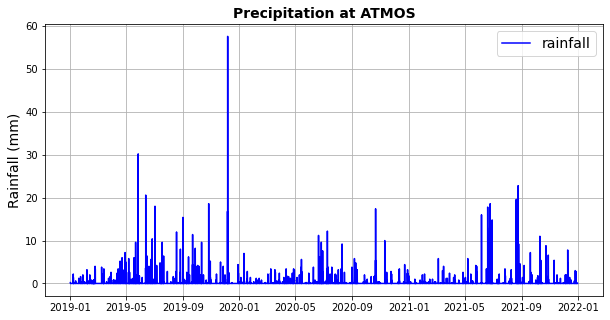

In [17]:
fig,ax1 = plt.subplots(figsize=(10,5))
ax1.plot(all_data['Date'],all_data['Precip'].values, label="rainfall",color='blue')
ax1.set_ylabel('Rainfall (mm)', fontsize =14)
ax1.set_title("Precipitation at ATMOS",fontweight="bold", fontsize=14)
ax1.legend(fontsize=14)
plt.grid()
plt.savefig('ATMOS_precip.png', dpi=300)

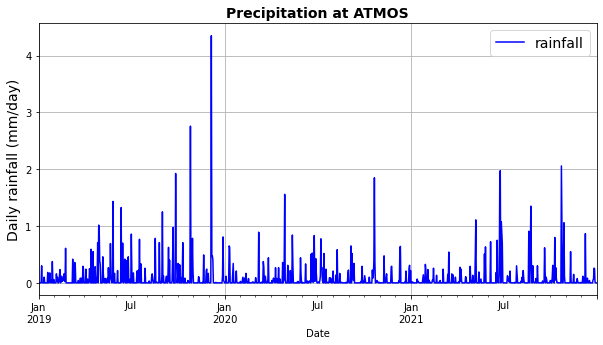

In [19]:
fig,ax1 = plt.subplots(figsize=(10,5))
all_data.groupby(pd.PeriodIndex(all_data['Date'], freq="D"))['Precip'].mean().plot(ax=ax1,label='rainfall',color='blue')
ax1.set_ylabel('Daily rainfall (mm/day)', fontsize =14)
ax1.set_title("Precipitation at ATMOS",fontweight="bold", fontsize=14)
ax1.legend(fontsize=14)
plt.grid()
plt.savefig('ATMOS_daily.png', dpi=300)